In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

[-5.         -4.98998999 -4.97997998 -4.96996997 -4.95995996] [ 4.95995996  4.96996997  4.97997998  4.98998999  5.        ]


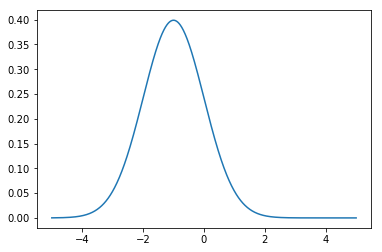

In [2]:
mu, sigma = -1, 1
xs = np.linspace(-5, 5, 1000)
print(xs[:5], xs[-5:])
plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma))

In [3]:
TRAIN_ITERS = 10000
M = 200 # minibatch size

In [4]:
# MLP - used for D_pre, D1, D2, G networks
def mlp(inputs, output_dim):
    # construct learnable parameters within local scope
    w0 = tf.get_variable("w0", [inputs.get_shape()[1], 6], initializer=tf.random_normal_initializer())
    b0 = tf.get_variable("b0", [6], initializer=tf.constant_initializer(0.0))
    w1 = tf.get_variable("w1", [6, 5], initializer=tf.random_normal_initializer())
    b1 = tf.get_variable("b1", [5], initializer=tf.constant_initializer(0.0))
    w2 = tf.get_variable("w2", [5,output_dim], initializer=tf.random_normal_initializer())
    b2 = tf.get_variable("b2", [output_dim], initializer=tf.constant_initializer(0.0))
    
    print(w0.name)
    print(b0.name)
    
    # nn operators
    fc0 = tf.nn.tanh(tf.matmul(inputs, w0) + b0)
    fc1 = tf.nn.tanh(tf.matmul(fc0, w1) + b1)
    fc2 = tf.nn.tanh(tf.matmul(fc1, w2) + b2)
    
    print(fc0.name)
    print(fc1.name)
    print(fc2.name)
    return fc2, [w0, b0, w1, b1, w2, b2]

In [5]:
# re-used for optimizing all networks
def momentum_optimizer(loss, var_list):
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        0.001,  # Base learning rate.
        batch,  # Current index into the dataset.
        TRAIN_ITERS // 4,  # Decay step - this decays 4 times throughout training process.
        0.95,   # Decay rate.
        staircase=True)
    #optimizer=tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=batch,var_list=var_list)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.6).minimize(loss, global_step=batch, var_list=var_list)
    return optimizer

### Pre-train Decision surface

In [6]:
with tf.variable_scope("D_pre"):
    input_node = tf.placeholder(tf.float32, shape=(M, 1))
    print(input_node.name)
    train_labels = tf.placeholder(tf.float32, shape=(M, 1))
    print(train_labels.name)
    D, theta = mlp(input_node, 1)
    loss = tf.reduce_mean(tf.square(D - train_labels))

D_pre/Placeholder:0
D_pre/Placeholder_1:0
D_pre/w0:0
D_pre/b0:0
D_pre/Tanh:0
D_pre/Tanh_1:0
D_pre/Tanh_2:0


In [7]:
optimizer = momentum_optimizer(loss, None)
print(optimizer.name)

Momentum


In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
# plot decision surface
def plot_d0(D, input_node):
    print(input_node.name)
    f, ax = plt.subplots(1)
    r = 1000 # resolution (number of points)
    
    # p_data
    xs = np.linspace(-5, 5, r)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')
    # decision boundary
    
    xs = np.linspace(-5, 5, r)
    ds = np.zeros((r, 1)) # decision surface
    
    # process multiple points in parallel in a minibatch
    for i in range(r//M):
        x = np.reshape(xs[M*i:M*(i+1)], (M, 1))
        ds[M*i:M*(i+1)] = sess.run(D, {input_node: x})

    ax.plot(xs, ds, label='decision boundary')
    ax.set_ylim(0, 1.1)
    plt.legend()

D_pre/Tanh_2:0
D_pre/Placeholder:0
D_pre/Placeholder:0


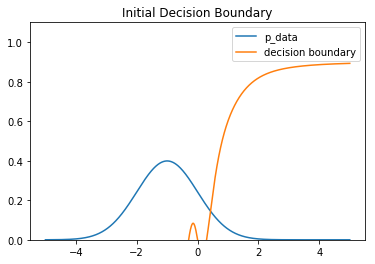

In [10]:
print(D.name)
print(input_node.name)
plot_d0(D, input_node)
plt.title('Initial Decision Boundary')

In [14]:
lh = np.zeros(1000)
for i in range(1000):
    #d=np.random.normal(mu,sigma,M)
    d = (np.random.random(M) - 0.5) * 10.0 # instead of sampling only from gaussian, want the domain to be covered as uniformly as possible
    labels = norm.pdf(d, loc=mu, scale=sigma)
    lh[i], _ = sess.run([loss, optimizer], {input_node: np.reshape(d, [M, 1]), train_labels: np.reshape(labels, [M, 1])})

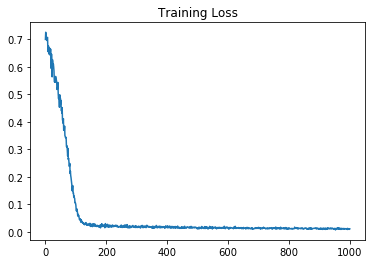

In [15]:
# training loss
plt.plot(lh)
plt.title('Training Loss')

D_pre/Placeholder:0


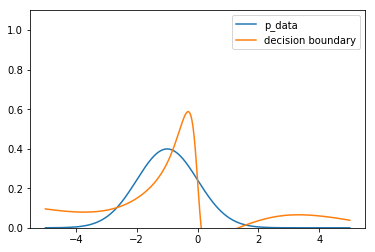

In [16]:
plot_d0(D, input_node)

In [17]:
# copy the learned weights over into a tmp array
weightsD = sess.run(theta)

In [18]:
# close the pre-training session
sess.close()

### Build Net
* actual generative adversarial network

In [19]:
with tf.variable_scope("G"):
    z_node = tf.placeholder(tf.float32, shape=[M, 1]) # M uniform01 floats
    G, theta_g = mlp(z_node, 1) # generate normal transformation of Z
    G = tf.multiply(5.0, G) # scale up by 5 to match range

G/w0:0
G/b0:0
G/Tanh:0
G/Tanh_1:0
G/Tanh_2:0


In [20]:
with tf.variable_scope("D") as scope:
    # D(x)
    x_node = tf.placeholder(tf.float32, shape=[M,1]) # input M normally distributed floats
    fc, theta_d = mlp(x_node, 1) # output likelihood of being normally distributed
    D1 = tf.maximum(tf.minimum(fc, 0.99), 0.01) # clamp as a probability
    # make a copy of D that uses the same variables, but takes in G as input
    scope.reuse_variables()
    fc, theta_d = mlp(G, 1)
    D2 = tf.maximum(tf.minimum(fc, 0.99), 0.01)

D/w0:0
D/b0:0
D/Tanh:0
D/Tanh_1:0
D/Tanh_2:0
D/w0:0
D/b0:0
D/Tanh_3:0
D/Tanh_4:0
D/Tanh_5:0


In [21]:
obj_d = tf.reduce_mean(tf.log(D1)+tf.log(1-D2))
obj_g = tf.reduce_mean(tf.log(D2))

In [22]:
# set up optimizer for G,D
opt_d = momentum_optimizer(1-obj_d, theta_d)
opt_g = momentum_optimizer(1-obj_g, theta_g) # maximize log(D(G(z)))

In [23]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [24]:
# copy weights from pre-training over to new D network
for i,v in enumerate(theta_d):
    sess.run(v.assign(weightsD[i]))

In [29]:
def plot_fig():
    # plots pg, pdata, decision boundary 
    f,ax=plt.subplots(1)
    # p_data
    xs = np.linspace(-5, 5, 1000)
    ax.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    # decision boundary
    r = 5000 # resolution (number of points)
    xs=np.linspace(-5, 5, r)
    ds=np.zeros((r, 1)) # decision surface
    # process multiple points in parallel in same minibatch
    for i in range(r//M):
        x=np.reshape(xs[M*i:M*(i+1)],(M,1))
        ds[M*i:M*(i+1)]=sess.run(D1, {x_node: x})

    ax.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs=np.linspace(-5, 5, r)
    gs=np.zeros((r, 1)) # generator function
    for i in range(r//M):
        z=np.reshape(zs[M*i:M*(i+1)],(M,1))
        gs[M*i:M*(i+1)]=sess.run(G, {z_node: z})
    histc, edges = np.histogram(gs, bins = 10)
    ax.plot(np.linspace(-5, 5, 10), histc/float(r), label='p_g')

    # ylim, legend
    ax.set_ylim(0,1.1)
    plt.legend()

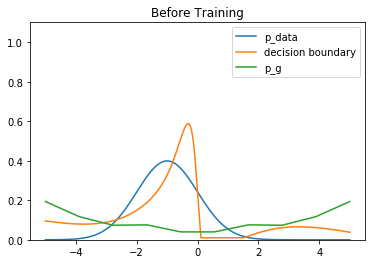

In [30]:
# initial conditions
plot_fig()
plt.title('Before Training')

In [31]:
# Algorithm 1 of Goodfellow et al 2014
k = 1
histd, histg = np.zeros(TRAIN_ITERS), np.zeros(TRAIN_ITERS)
for i in range(TRAIN_ITERS):
    for j in range(k):
        x = np.random.normal(mu, sigma, M) # sampled m-batch from p_data
        x.sort()
        z = np.linspace(-5.0, 5.0, M) + np.random.random(M)*0.01  # sample m-batch from noise prior
        histd[i], _ = sess.run([obj_d, opt_d], {x_node: np.reshape(x, [M,1]), z_node: np.reshape(z, [M,1])})
    z = np.linspace(-5.0, 5.0, M) + np.random.random(M)*0.01 # sample noise prior
    histg[i], _ = sess.run([obj_g, opt_g], {z_node: np.reshape(z, [M,1])}) # update generator
    if i % (TRAIN_ITERS//10) == 0:
        print(float(i)/float(TRAIN_ITERS))

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


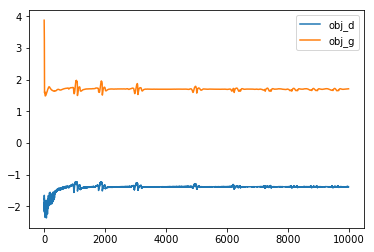

In [32]:
plt.plot(range(TRAIN_ITERS), histd, label='obj_d')
plt.plot(range(TRAIN_ITERS), 1-histg, label='obj_g')
plt.legend()

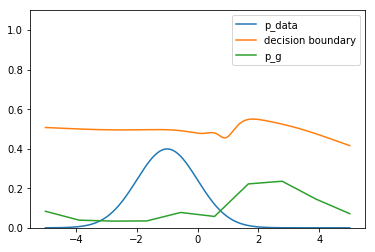

In [33]:
plot_fig()